# Load observation dataset

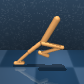

In [1]:
import torch
import gzip
import pickle
import torch.nn.functional as F
from PIL import Image
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd 
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

indices = np.random.choice(10000, 1000, replace=False)

with gzip.open('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/analysis/walker_walk_obs/train_env_obs.gzip', 'rb') as f:
    train_sampled_obs = pickle.load(f)[indices]
with gzip.open('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/analysis/walker_walk_obs/ch_env_obs.gzip', 'rb') as f:
    ch_sampled_obs = pickle.load(f)[indices]
with gzip.open('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/analysis/walker_walk_obs/vh_env_obs.gzip', 'rb') as f:
    vh_sampled_obs = pickle.load(f)[indices]
with gzip.open('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/analysis/walker_walk_obs/dist01_sampled_obs.gzip', 'rb') as f:
    dist01_sampled_obs = pickle.load(f)[indices]
with gzip.open('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/analysis/walker_walk_obs/dist02_sampled_obs.gzip', 'rb') as f:
    dist02_sampled_obs = pickle.load(f)[indices]
with gzip.open('/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/analysis/walker_walk_obs/dist05_sampled_obs.gzip', 'rb') as f:
    dist05_sampled_obs = pickle.load(f)[indices]

test_image = np.uint8(train_sampled_obs[5][:3].transpose(1,2,0))
image = Image.fromarray(test_image)
image

# Load models

In [4]:
import torch

envs = ['walker_walk', 'walker_stand']

cnn4_ro_agents = {}
for env in envs:
    cnn4_ro_agents[env] = {}
    for i in range(5):
        agent = torch.load(f'/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs/Hansen_repo/svea_cnn4_randomoverlay/svea/cnn_4_random_overlay/{env}/{i}/model/500000.pt')
        agent.actor = agent.actor.cuda()
        agent.critic = agent.critic.cuda()
        cnn4_ro_agents[env][i] = agent


cnn11_ro_agents = {}
for env in envs:
    cnn11_ro_agents[env] = {}
    for i in range(5):
        agent = torch.load(f'/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs/Hansen_repo/svea_cnn11_randomoverlay/svea/cnn_11_random_overlay/{env}/{i}/model/500000.pt')
        agent.actor = agent.actor.cuda()
        agent.critic = agent.critic.cuda()
        cnn11_ro_agents[env][i] = agent


cnn11_cmb_agents = {}
for env in envs:
    cnn11_cmb_agents[env] = {}
    for i in range(5):
        agent = torch.load(f'/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs/Hansen_repo/svea_cnn11_combo/svea/cnn_11_combo/{env}/{i}/model/500000.pt')
        agent.actor = agent.actor.cuda()
        agent.critic = agent.critic.cuda()
        cnn11_cmb_agents[env][i] = agent      


cnn11_7mb_agents = {}
for env in envs:
    cnn11_7mb_agents[env] = {}
    for i in range(5):
        agent = torch.load(f'/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs/svea_new_combo/svea_cnn11_combo_7types/svea/cnn_11_combo/{env}/{i}/model/500000.pt')
        agent.actor = agent.actor.cuda()
        agent.critic = agent.critic.cuda()
        cnn11_7mb_agents[env][i] = agent      

all_agents = {
          'cnn4_ro': cnn4_ro_agents, 
          'cnn11_ro': cnn11_ro_agents,
          'cnn11_cmb': cnn11_cmb_agents,
          'cnn11_7cmn': cnn11_7mb_agents
          }

1. Aug obs 와 Train obs의 Q value가 동일한지
2. Encoder의 output embedding의 cosine similarity

In [5]:
def get_similarities(data_dict):
    train_data = data_dict['train']
    ch_data = data_dict['ch']
    vh_data = data_dict['vh']
    dist01_data = data_dict['dist01']
    dist02_data = data_dict['dist02']
    dist05_data = data_dict['dist05']
    
    ch_cosine_similarity = F.cosine_similarity(train_data, ch_data, dim=1).mean().item()
    vh_cosine_similarity = F.cosine_similarity(train_data, vh_data, dim=1).mean().item()
    dist01_cosine_similarity = F.cosine_similarity(train_data, dist01_data, dim=1).mean().item()
    dist02_cosine_similarity = F.cosine_similarity(train_data, dist02_data, dim=1).mean().item()
    dist05_cosine_similarity = F.cosine_similarity(train_data, dist05_data, dim=1).mean().item()
    
    return {'ch': ch_cosine_similarity, 
            'vh': vh_cosine_similarity, 
            'dist01': dist01_cosine_similarity,
            'dist02': dist02_cosine_similarity,
            'dist05':dist05_cosine_similarity}

# Load train_score, eval_score from wandb

In [6]:
import wandb
from tqdm.auto import tqdm

def collect_runs(project_name, group_exp_name_list, metric_list, metric_list_with_dist):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(project_name)
    group_list, exp_list, summary_list, config_list, seeds = [], [], [], [], []
    train_list, ch_list, vh_list = [], [], []
    dist01_list, dist02_list, dist03_list, dist04_list, dist05_list = [], [], [], [], []
    
    for rn in tqdm(runs):         
        
        # filter out unfinished runs
        flags = False
        if 'train/frame' in rn.summary:
            if rn.summary['train/frame'] == 500000:
                flags=True
        if flags == False:
            continue
        # filter out unselected group_name, exp_name
        flags = False
        for g_e in group_exp_name_list:
            g, e = g_e
            if (rn.config['group_name']==g) & (rn.config['exp_name']==e):
                flags = True
        if flags == False:
            continue

        # 'svea_cnn11_combo_7types' -> get distracting_scores
        group_name = rn.config['group_name']
        exp_name = rn.config['exp_name']
        # TODO: 아래처럼 hard coding으로 박기 싫은디
        if exp_name == 'svea_cnn11_combo_7types':
            metrics = metric_list_with_dist
        else:
            metrics = metric_list

        # get scores
        scores_dict = {}
        seed = rn.config['seed']
        try:
            for metric in metrics:
                scores_dict[metric] = rn.summary[metric]
        except:
            print(f'{group_name}_{exp_name}에서 뭔가 결과 불러올 때 오류. seed={seed}')
            continue
   
        # make df
        group_list.append(group_name)
        exp_list.append(exp_name)
        seeds.append(seed)
        config_list.append(
            {k: v for k,v in rn.config.items()
              if not k.startswith('_')}
        )
        summary_list.append(rn.summary._json_dict)
        # TODO: metric_list에서 뭔가 자동으로 들어가게 하고싶은데
        train_list.append(scores_dict['eval/train_episode_return'])
        ch_list.append(scores_dict['eval/color_hard_final_episode_return'])
        vh_list.append(scores_dict['eval/video_hard_final_episode_return'])
        # TODO: change hard coding
        if exp_name == 'svea_cnn11_combo_7types':
            dist01_list.append(scores_dict['eval/distractingcs_01_final_episode_return'])
            dist02_list.append(scores_dict['eval/distractingcs_02_final_episode_return'])
            dist03_list.append(scores_dict['eval/distractingcs_03_final_episode_return'])
            dist04_list.append(scores_dict['eval/distractingcs_04_final_episode_return'])
            dist05_list.append(scores_dict['eval/distractingcs_01_final_episode_return'])
        else:
            dist01_list.append(-1)
            dist02_list.append(-1)
            dist03_list.append(-1)
            dist04_list.append(-1)
            dist05_list.append(-1)
        
    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "seed": seeds,
        'group_name': group_list,
        'exp_name': exp_list,
        'train_score': train_list,
        'ch_score': ch_list,
        'vh_score': vh_list,
        'dist01_score': dist01_list,
        'dist02_score': dist02_list,
        'dist03_score': dist03_list,
        'dist04_score': dist04_list,
        'dist05_score': dist05_list
        })    
    return runs_df

### get ch,vh results from Gen4RL_dmcgb

In [7]:
project_name = 'draftrec/Gen4RL_dmcgb'
group_exp_name_list = [
    ('Hansen_repo', 'svea_cnn4_randomoverlay'),
    ("Hansen_repo", "svea_cnn11_randomoverlay"),
    ("Hansen_repo", "svea_impala_randomoverlay"),
    ("Hansen_repo", "svea_cnn11_combo"),
    ("dmcgb_reset", "svea_cnn4_randomoverlay_policy_reset_rr1"), 
    ("dmcgb_reset", "svea_cnn11_randomoverlay_policy_reset_rr1"),
    ("svea_new_combo", 'svea_cnn11_combo_7types')
]

metric_list = [
    'eval/train_episode_return',
    # 'eval/color_easy_final_episode_return',
    'eval/color_hard_final_episode_return',
    # 'eval/video_easy_final_episode_return',
    'eval/video_hard_final_episode_return'
]

metric_list_with_dist = [
    'eval/train_episode_return',
    # 'eval/color_easy_final_episode_return',
    'eval/color_hard_final_episode_return',
    # 'eval/video_easy_final_episode_return',
    'eval/video_hard_final_episode_return',
    'eval/distractingcs_01_final_episode_return',  # distracting: svea_cnn11_combo_7types은 wandb의 결과로 확인한다
    'eval/distractingcs_02_final_episode_return',
    'eval/distractingcs_03_final_episode_return',
    'eval/distractingcs_04_final_episode_return',
    'eval/distractingcs_05_final_episode_return'
]

runs_df = collect_runs(project_name, group_exp_name_list, metric_list, metric_list_with_dist)
runs_df

  0%|          | 0/1233 [00:00<?, ?it/s]

,summary,config,seed,group_name,exp_name,train_score,ch_score,vh_score,dist01_score,dist02_score,dist03_score,dist04_score,dist05_score
0,"{'_step': 500000, 'eval/episode': 500, 'train/...","{'env': {'task': 'catch', 'domain': 'ball_in_c...",4,svea_new_combo,svea_cnn11_combo_7types,930.600000,934.300000,264.100000,293.900000,16.900000,136.400000,140.500000,293.900000
1,"{'train/frame': 500000, 'eval/episode': 500, '...","{'env': {'task': 'swingup', 'domain': 'cartpol...",4,svea_new_combo,svea_cnn11_combo_7types,833.432984,538.754684,291.817282,151.295012,136.450020,161.473424,170.096705,151.295012
2,"{'train/critic_loss': 1.338457465171814, 'eval...","{'env': {'task': 'run', 'domain': 'cheetah'}, ...",4,svea_new_combo,svea_cnn11_combo_7types,236.715219,216.927687,126.868802,92.905247,89.132727,74.918332,47.659489,92.905247
3,{'eval/distractingcs_03_final_episode_return':...,"{'env': {'task': 'spin', 'domain': 'finger'}, ...",4,svea_new_combo,svea_cnn11_combo_7types,982.700000,967.300000,696.600000,584.600000,209.100000,184.200000,41.300000,584.600000
4,"{'_wandb': {'runtime': 25849}, 'train/actor_lo...","{'env': {'task': 'easy', 'domain': 'reacher'},...",4,svea_new_combo,svea_cnn11_combo_7types,84.700000,201.800000,86.100000,46.100000,47.400000,70.400000,63.300000,46.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,"{'eval/duration': 1203.9335525035858, 'train/a...","{'env': {'task': 'run', 'domain': 'cheetah'}, ...",0,Hansen_repo,svea_cnn4_randomoverlay,339.964895,313.128263,122.140417,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
241,"{'eval/video_easy_episode_return': 509.3, '_wa...","{'env': {'task': 'spin', 'domain': 'finger'}, ...",0,Hansen_repo,svea_cnn4_randomoverlay,636.500000,610.000000,165.600000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
242,"{'_runtime': 19826.56497502327, 'eval/episode'...","{'env': {'task': 'easy', 'domain': 'reacher'},...",0,Hansen_repo,svea_cnn4_randomoverlay,743.900000,534.700000,420.600000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
243,"{'train/alpha_loss': -0.030996114015579224, 't...","{'env': {'task': 'swingup', 'domain': 'cartpol...",0,Hansen_repo,svea_cnn4_randomoverlay,833.798483,730.435808,295.895510,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


### get distracting results from local folder

In [10]:
def load_data(log_dir, exp_name):
    # Replace with your data loading logic
    exp_log_dir = Path(log_dir) / exp_name
    # Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
    distracting_cs_pt_files = glob.glob(str(exp_log_dir / '**' / 'distractingcs_evalresults.pt'), recursive=True)
    
    # Create a dictionary with keys as "domain_task" and values as paths to .pt files
    distracting_cs_pt_files_dict = {}
    
    for pt_file in distracting_cs_pt_files:
        # Split the file path into components
        components = pt_file.split(os.sep)
        # Get the domain and task names (adjust the indices as per your directory structure)
        if log_dir == rl_playground_log_dir:
            domain_name = components[-5]
            task_name = components[-3]
        else:
            domain_name = components[-3]
            task_name = components[-2]

        # Create a key combining domain and task names
        key = f"{domain_name}_{task_name}"
        
        # Add the file path to the dictionary
        distracting_cs_pt_files_dict[key] = torch.load(pt_file)
    
    # Print the dictionary
    print(len(distracting_cs_pt_files_dict.keys()))
    #assert len(distracting_cs_pt_files_dict.keys()) == 35

    # Dictionary to store rewards per task (domain_task as key)
    reward_data = defaultdict(lambda: defaultdict(list))

    # Populate reward_data with reward values from data_dict
    for key, value in distracting_cs_pt_files_dict.items():
        if log_dir == rl_playground_log_dir:
            domain_task = "_".join(key.split("_")[:-2])
            reward_data[domain_task]['01'].append(value.get('distracting_cs_01', 0))
            reward_data[domain_task]['02'].append(value.get('distracting_cs_02', 0))
            reward_data[domain_task]['03'].append(value.get('distracting_cs_03', 0))
            reward_data[domain_task]['04'].append(value.get('distracting_cs_04', 0))
            reward_data[domain_task]['05'].append(value.get('distracting_cs_05', 0))
        else:
            domain_task = "_".join(key.split("_")[:-1])
            reward_data[domain_task]['01'].append(value.get('distractingcs 01 reward', 0))
            reward_data[domain_task]['02'].append(value.get('distractingcs 02 reward', 0))
            reward_data[domain_task]['03'].append(value.get('distractingcs 03 reward', 0))
            reward_data[domain_task]['04'].append(value.get('distractingcs 04 reward', 0))
            reward_data[domain_task]['05'].append(value.get('distractingcs 05 reward', 0))

    # Creating a DataFrame to hold all the data
    data = []

    for task, rewards in reward_data.items():
        data.append([task, '01', np.mean(rewards['01']), np.std(rewards['01'])])
        data.append([task, '02', np.mean(rewards['02']), np.std(rewards['02'])])
        data.append([task, '03', np.mean(rewards['03']), np.std(rewards['03'])])
        data.append([task, '04', np.mean(rewards['04']), np.std(rewards['04'])])
        data.append([task, '05', np.mean(rewards['05']), np.std(rewards['05'])])
    
    df = pd.DataFrame(data, columns=['Task', 'Reward Type', 'Average Reward', 'STD'])
    df['Exp Name'] = exp_name
    return df

In [ ]:
log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"
rl_playground_log_dir = "/home/nas2_userI/byungkunlee/research/rl/RL_playground/dmc/pretrained_model"

exp_names = ["Hansen_repo/svea_cnn4_randomoverlay", 
             "Hansen_repo/svea_cnn11_randomoverlay",             
             "Hansen_repo/svea_impala_randomoverlay",
             "Hansen_repo/svea_cnn11_combo"
             ] 
rl_playground_exp_names = []

# Create a DataFrame for each exp_name and store them in a list
hansen_dfs = [load_data(log_dir, exp_name) for exp_name in exp_names]
rl_playground_dfs = [load_data(rl_playground_log_dir, exp_name) for exp_name in rl_playground_exp_names]
hansen_dfs = hansen_dfs + rl_playground_dfs
# Concatenate all DataFrames
hansen_local_df = pd.concat(hansen_dfs, ignore_index=True)
hansen_local_df

35
35
35
35


,Task,Reward Type,Average Reward,STD,Exp Name
0,walker_walk,01,263.608417,120.763431,Hansen_repo/svea_cnn4_randomoverlay
1,walker_walk,02,127.671477,52.744519,Hansen_repo/svea_cnn4_randomoverlay
2,walker_walk,03,92.822586,28.701372,Hansen_repo/svea_cnn4_randomoverlay
3,walker_walk,04,72.301844,17.355036,Hansen_repo/svea_cnn4_randomoverlay
4,walker_walk,05,66.531868,13.590551,Hansen_repo/svea_cnn4_randomoverlay
...,...,...,...,...,...
135,ball_in_cup_catch,01,283.940000,152.949563,Hansen_repo/svea_cnn11_combo
136,ball_in_cup_catch,02,229.896000,127.001848,Hansen_repo/svea_cnn11_combo
137,ball_in_cup_catch,03,147.214000,74.079406,Hansen_repo/svea_cnn11_combo
138,ball_in_cup_catch,04,110.196000,27.404466,Hansen_repo/svea_cnn11_combo


In [19]:
unique_reward_types = df['Reward Type'].unique()
unique_reward_types

array(['01', '02', '03', '04', '05'], dtype=object)

In [22]:
# TODO
runs_df[runs_df['exp_name']=='svea_cnn11_combo']

,summary,config,seed,group_name,exp_name,train_score,ch_score,vh_score,dist01_score,dist02_score,dist03_score,dist04_score,dist05_score
41,"{'_step': 500000, 'train/episode_return': 985,...","{'env': {'task': 'catch', 'domain': 'ball_in_c...",4,Hansen_repo,svea_cnn11_combo,976.600000,955.800000,743.600000,-1.0,-1.0,-1.0,-1.0,-1.0
42,"{'_runtime': 16525.859253168106, 'train/episod...","{'env': {'task': 'swingup', 'domain': 'cartpol...",4,Hansen_repo,svea_cnn11_combo,779.602033,731.237052,335.341418,-1.0,-1.0,-1.0,-1.0,-1.0
43,{'eval/color_easy_episode_return': 187.7660135...,"{'env': {'task': 'run', 'domain': 'cheetah'}, ...",4,Hansen_repo,svea_cnn11_combo,242.566737,177.115127,129.473301,-1.0,-1.0,-1.0,-1.0,-1.0
45,"{'_wandb': {'runtime': 35148}, '_timestamp': 1...","{'env': {'task': 'spin', 'domain': 'finger'}, ...",4,Hansen_repo,svea_cnn11_combo,981.500000,968.900000,754.000000,-1.0,-1.0,-1.0,-1.0,-1.0
46,{'eval/color_easy_final_episode_return': 112.9...,"{'env': {'task': 'easy', 'domain': 'reacher'},...",4,Hansen_repo,svea_cnn11_combo,20.700000,106.100000,168.700000,-1.0,-1.0,-1.0,-1.0,-1.0
47,"{'train/critic_loss': 13.52781105041504, 'eval...","{'env': {'task': 'stand', 'domain': 'walker'},...",4,Hansen_repo,svea_cnn11_combo,953.526804,949.172679,799.951407,-1.0,-1.0,-1.0,-1.0,-1.0
48,"{'train/critic_loss': 5.118058204650879, 'eval...","{'env': {'task': 'walk', 'domain': 'walker'}, ...",4,Hansen_repo,svea_cnn11_combo,905.105641,861.994177,527.484517,-1.0,-1.0,-1.0,-1.0,-1.0
51,"{'eval/train_episode_return': 969, 'eval/color...","{'env': {'task': 'catch', 'domain': 'ball_in_c...",3,Hansen_repo,svea_cnn11_combo,969.000000,940.600000,497.700000,-1.0,-1.0,-1.0,-1.0,-1.0
52,"{'train/episode': 501, 'train/critic_loss': 12...","{'env': {'task': 'swingup', 'domain': 'cartpol...",3,Hansen_repo,svea_cnn11_combo,773.603067,718.022092,419.033017,-1.0,-1.0,-1.0,-1.0,-1.0
55,"{'train/actor_loss': -71.29913330078125, 'eval...","{'env': {'task': 'run', 'domain': 'cheetah'}, ...",3,Hansen_repo,svea_cnn11_combo,253.929203,187.382204,131.294910,-1.0,-1.0,-1.0,-1.0,-1.0


# Cosine similarity between different eval environments

## cnn output feature similarity

In [ ]:
def get_cnn_features(agent, start_idx=0):
    train_obs = torch.FloatTensor(train_sampled_obs[start_idx:start_idx+100]).cuda()
    with torch.no_grad():
        train_obs_features = agent.actor.encoder.shared_cnn(train_obs).reshape(train_obs.shape[0], -1)
    
    ch_obs = torch.FloatTensor(ch_sampled_obs[start_idx:start_idx+100]).cuda()
    with torch.no_grad():
        ch_obs_features = agent.actor.encoder.shared_cnn(ch_obs).reshape(ch_obs.shape[0], -1)
    
    vh_obs = torch.FloatTensor(vh_sampled_obs[start_idx:start_idx+100]).cuda()
    with torch.no_grad():
        vh_obs_features = agent.actor.encoder.shared_cnn(vh_obs).reshape(vh_obs.shape[0], -1)
    
    dist01_obs = torch.FloatTensor(dist01_sampled_obs[start_idx:start_idx+100]).cuda()
    with torch.no_grad():
        dist01_obs_features = agent.actor.encoder.shared_cnn(dist01_obs).reshape(dist01_obs.shape[0], -1)
    
    dist02_obs = torch.FloatTensor(dist02_sampled_obs[start_idx:start_idx+100]).cuda()
    with torch.no_grad():
        dist02_obs_features = agent.actor.encoder.shared_cnn(dist02_obs).reshape(dist02_obs.shape[0], -1)
    
    dist05_obs = torch.FloatTensor(dist05_sampled_obs[start_idx:start_idx+100]).cuda()
    with torch.no_grad():
        dist05_obs_features = agent.actor.encoder.shared_cnn(dist05_obs).reshape(dist05_obs.shape[0], -1)
    
    return {'train':train_obs_features,
            'ch':ch_obs_features,
            'vh':vh_obs_features,
            'dist01':dist01_obs_features,
            'dist02':dist02_obs_features,
            'dist05':dist05_obs_features}

In [40]:
encoder_data = {}
for agent_name, env_seed_evalenv in all_agents.items():
    encoder_data[agent_name] = {}
    for env, seed_evalenv in env_seed_evalenv.items():
        encoder_data[agent_name][env] = {}
        for seed, evalenv in seed_evalenv.items():
            encoder_data[agent_name][env][seed] = get_cnn_features(evalenv, start_idx=0)

similarities = {}
sums = {}
counts = {}

for model in encoder_data:
    for task in encoder_data[model]:
        for seed, eval_env_score in encoder_data[model][env].items():
            score = get_similarities(eval_env_score)
            for eval_env, eval_score in score.items():
                
                # Initialize dictionary levels if not present
                if task not in similarities:
                    similarities[task] = {}
                    sums[task] = {}
                    counts[task] = {}

                if eval_env not in similarities[task]:
                    similarities[task][eval_env] = {}
                    sums[task][eval_env] = {}
                    counts[task][eval_env] = {}

                if model not in similarities[task][eval_env]:
                    similarities[task][eval_env][model] = 0
                    sums[task][eval_env][model] = 0
                    counts[task][eval_env][model] = 0

                # Add to the running sums and counts
                sums[task][eval_env][model] += eval_score
                counts[task][eval_env][model] += 1

# Calculate the average scores
for task in sums:
    for eval_env in sums[task]:
        for model in sums[task][eval_env]:
            similarities[task][eval_env][model] = sums[task][eval_env][model] / counts[task][eval_env][model]

similarities

/home/nas2_userI/dongyoonhwang/anaconda3/envs/hansen_dmcgb/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'walker_walk': {'ch': {'cnn4_ro': 0.46119036674499514,
   'cnn11_ro': 0.5375908017158508,
   'cnn11_cmb': 0.5919120907783508,
   'cnn11_7cmn': 0.6081829309463501},
  'vh': {'cnn4_ro': 0.2899119257926941,
   'cnn11_ro': 0.4466738522052765,
   'cnn11_cmb': 0.5107797682285309,
   'cnn11_7cmn': 0.4655477225780487},
  'dist01': {'cnn4_ro': 0.2932316601276398,
   'cnn11_ro': 0.4373577356338501,
   'cnn11_cmb': 0.47818357348442075,
   'cnn11_7cmn': 0.566622257232666},
  'dist02': {'cnn4_ro': 0.2181767165660858,
   'cnn11_ro': 0.34156458377838134,
   'cnn11_cmb': 0.3889395177364349,
   'cnn11_7cmn': 0.44996618628501894},
  'dist05': {'cnn4_ro': 0.098868927359581,
   'cnn11_ro': 0.15274139046669005,
   'cnn11_cmb': 0.1837072491645813,
   'cnn11_7cmn': 0.22400788962841034}},
 'walker_stand': {'ch': {'cnn4_ro': 0.46119036674499514,
   'cnn11_ro': 0.5375908017158508,
   'cnn11_cmb': 0.5919120907783508,
   'cnn11_7cmn': 0.6081829309463501},
  'vh': {'cnn4_ro': 0.2899119257926941,
   'cnn11_ro': 0.

# TODO
- eval_train_score 나오게
- eval_envs_score 나오게

### cosine similarity of encoder output $f_\theta$

In [ ]:
log_dir = "/home/nas2_userI/dongyoonhwang/dmcontrol-generalization-benchmark/logs"
exp_name = ["Hansen_repo/svea_cnn11_combo", "Hansen_repo/svea_cnn11_randomoverlay", "Hansen_repo/svea_cnn4_randomoverlay",
           "Hansen_repo/svea_impala_randomoverlay"]
domain_task_name = "walker_walk"
seed= "0"

distracting_results = {}
for exp in exp_name:
    # Replace with your data loading logic
    exp_log_dir = Path(log_dir) / exp
    # Traverse through all distractingcs_evalresults.pt files and collect their paths and seed numbers
    distracting_cs_pt_files = glob.glob(str(exp_log_dir / '**'/ domain_task_name / seed / '**'/ 'distractingcs_evalresults.pt'), recursive=True)
    distracting_results[exp] = {}
    for key, value in torch.load(distracting_cs_pt_files[0]).items():
        if key == 'args':
            continue
        distracting_results[exp][key] = value
    

distracting_results

        